<a href="https://colab.research.google.com/github/songlinhou/pytools/blob/master/DecisionTreeWithFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip uninstall mlxtend
!pip install mlxtend

In [0]:
class FATree:
    def __init__(self,estimator):
        self.estimator = estimator
        pass

    def get_binary_features(self,X):
        data_binary = []
        for rowid,row in X.iterrows():
            row_binary = row>(row.sum() / len(row))
            data_binary.append(row_binary)
        data_binary = np.array(data_binary)
        return data_binary

    def frequent_features(self,data_binary,all_feature_names,selection_ratio=0.1):
        s0 = data_binary.sum(axis=0) # how many elements in each bin
        s1 = pd.Series(s0,index=all_feature_names).sort_values(ascending=False)
        self.s2 = np.array(s1.keys())[0:int(len(s1.keys())*selection_ratio)]
        fnum = int(len(s1.keys())*selection_ratio)
        coverage = np.sum(np.array(s1.values)[0:fnum]) / s1.values.sum()
        return self.s2,coverage

    def frequence_list(self,data_binary,all_feature_names):
        from mlxtend.frequent_patterns import fpgrowth
        import pandas as pd
        s2 = self.s2
        binary_df = pd.DataFrame(data_binary,columns=all_feature_names)
        self.frequency_df = fpgrowth(binary_df[s2].astype(bool), min_support=0.5,max_len=4,use_colnames=True)


    def addtional_features(self,X,all_feature_names):
        frequency_df = self.frequency_df
        generated_features = {}
        for fset in frequency_df['itemsets'].values:
            # print(fset)
            fs = list(fset)
            if len(fs) == 1:
                continue
            col_name = '-'.join(fs)
            comb_f = X[fs].mean(axis=1) # just get the average value of the frequent columns
            generated_features[col_name] = comb_f

        add_df = pd.DataFrame(generated_features)
        return add_df

    def fit(self,X,y):
        import pandas as pd
        # from sklearn.tree import DecisionTreeClassifier
        data_binary = self.get_binary_features(X)
        all_feature_names = X.columns # X is a dataframe
        s2,coverage = self.frequent_features(data_binary,all_feature_names,selection_ratio=0.1)
        self.frequence_list(data_binary,all_feature_names)
        add_df = self.addtional_features(X,all_feature_names)
        new_X = pd.concat([X,add_df],axis=1)
        self.columns = new_X.columns
        self.model = self.estimator()
        self.model.fit(new_X,y)

    def score(self,X,y):
        import pandas as pd
        from sklearn.tree import DecisionTreeClassifier
        data_binary = self.get_binary_features(X)
        all_feature_names = X.columns # X is a dataframe
        add_df = self.addtional_features(X,all_feature_names)
        new_X = pd.concat([X,add_df],axis=1)
        return self.model.score(new_X,y)



In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_raw = pd.read_csv('sample_data/mnist_train_small.csv')
df_raw = df_raw[0:1000]
X_raw = df_raw.drop('6',axis=1)
y_raw = df_raw[['6']]
X_raw.shape,y_raw.shape

((1000, 784), (1000, 1))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_raw,y_raw,test_size=0.3)

In [0]:
from sklearn.tree import DecisionTreeClassifier
ft = FATree(DecisionTreeClassifier)
ft.fit(X_train,y_train)

In [41]:
ft.score(X_test,y_test)

0.7480659529577245

In [26]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt.score(X_test,y_test)

0.6633333333333333

In [43]:
from tqdm import tqdm_notebook
from sklearn.tree import DecisionTreeClassifier
dt_scores = []
ft_scores = []

df_raw = pd.read_csv('sample_data/mnist_train_small.csv')
bin_size = int(df_raw.shape[0]/10)
est = DecisionTreeClassifier

for bin_index in tqdm_notebook(range(10-1)):
    df_raw_part = df_raw[:(bin_index+1)*bin_size]
    X_raw = df_raw_part.drop('6',axis=1)
    y_raw = df_raw_part[['6']]
    for ts in (range(1,3)):
        test_size = 1 - ts*0.1
        X_train, X_test, y_train, y_test = train_test_split(X_raw,y_raw,test_size=test_size)

        dt = est()
        dt.fit(X_train,y_train)
        score1 = dt.score(X_test,y_test)
        dt_scores.append(score1)

        ft = FATree(est)
        ft.fit(X_train,y_train)
        score2 = ft.score(X_test,y_test)
        ft_scores.append(score2)

        print("DATA={} train_size={} test_size={} DT={} FT={}".format(X_raw.shape[0],X_train.shape[0],X_test.shape[0],score1,score2))

DATA=1999 train_size=199 test_size=1800 DT=0.51 FT=0.5211111111111111
DATA=1999 train_size=399 test_size=1600 DT=0.588125 FT=0.56625
DATA=3998 train_size=399 test_size=3599 DT=0.5868296749096972 FT=0.603500972492359
DATA=3998 train_size=799 test_size=3199 DT=0.6176930290715849 FT=0.6598937167864958
DATA=5997 train_size=599 test_size=5398 DT=0.6091144868469803 FT=0.618377176732123
DATA=5997 train_size=1199 test_size=4798 DT=0.6781992496873698 FT=0.6802834514380992
DATA=7996 train_size=799 test_size=7197 DT=0.6348478532721967 FT=0.6327636515214673
DATA=7996 train_size=1599 test_size=6397 DT=0.6961075504142566 FT=0.7037673909645146
DATA=9995 train_size=999 test_size=8996 DT=0.6771898621609604 FT=0.6724099599822143
DATA=9995 train_size=1999 test_size=7996 DT=0.7088544272136068 FT=0.7161080540270135
DATA=11994 train_size=1199 test_size=10795 DT=0.6851320055581288 FT=0.6619731357109773
DATA=11994 train_size=2398 test_size=9596 DT=0.7318674447686536 FT=0.7289495623176323
DATA=13993 train_size

In [0]:
import matplotlib.pyplot as plt

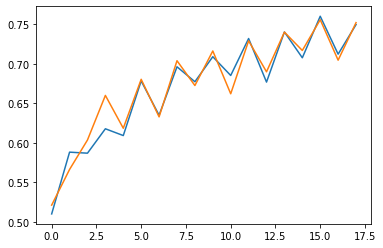

In [44]:
plt.plot(dt_scores)
plt.plot(ft_scores)

In [0]:
df_raw_1000 = df_raw[:1000]
X_raw_1000 = df_raw_1000.drop('6',axis=1)
y_raw_1000 = df_raw_1000[['6']]
X_train, X_test, y_train, y_test = train_test_split(X_raw_1000,y_raw_1000,test_size=0.2)

In [49]:
#estimation accuracy 1
vanilla_accs = []
for i in tqdm_notebook(range(100)):
    dt = DecisionTreeClassifier()
    dt.fit(X_train,y_train)
    vanilla_accs.append(dt.score(X_test,y_test))

In [50]:
#estimation accuracy 2
fa_accs = []
for i in tqdm_notebook(range(100)):
    ft = FATree(DecisionTreeClassifier)
    ft.fit(X_train,y_train)
    fa_accs.append(ft.score(X_test,y_test))

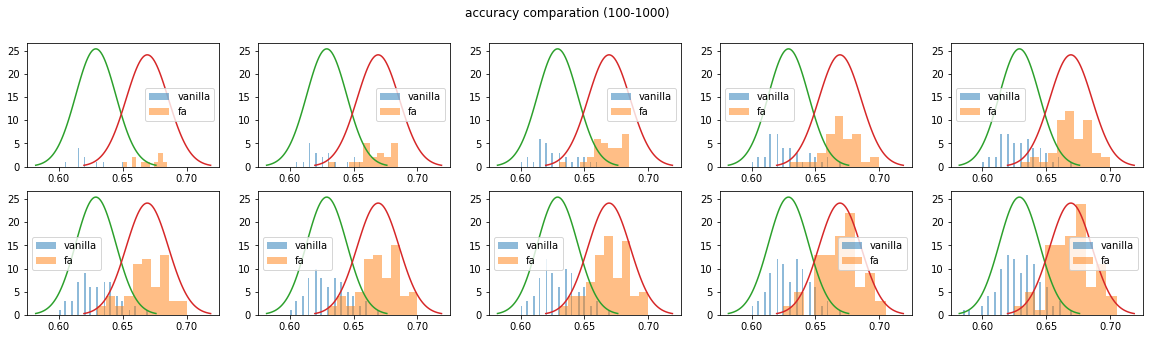

In [59]:
import scipy.stats as stats
import math

fig = plt.figure(figsize=(20,5))

for i in range(10):
    plot_index = i + 1
    plt.subplot(2, 5, plot_index)
    plt.hist(vanilla_accs[0:(i+1)*10],bins=50,label='vanilla',alpha = 0.5)
    plt.hist(fa_accs[0:(i+1)*10],bins=10,label='fa',alpha = 0.5)

    #gaussian curve
    mu = np.mean(vanilla_accs)
    variance = np.var(vanilla_accs)
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))
    #

    mu = np.mean(fa_accs)
    variance = np.var(fa_accs)
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))
    _=plt.legend()

# _= plt.title("accuracy comparation")
_= fig.suptitle("accuracy comparation (100-1000)")

When I test my assumption on the MNIST dataset. This is what I have found.

1. when the training size is small, such as 1000, 
preprocessing the feature using frequency analysis before using decision tree is more likely to perform better than the using decision tree alone.

2. when the training size is large, directly using decision tree usually performs better.

My initial thought is when the number of training records is not large, the newly added features offers information to decision tree when choosing which feature to split. When the training number grows, decision tree can get enough information from the original features, the additional features introduce more 

In [97]:
df_raw_1000 = df_raw[:1000]
X_raw_1000 = df_raw_1000.drop('6',axis=1)
y_raw_1000 = df_raw_1000[['6']]
X_train, X_test, y_train, y_test = train_test_split(X_raw_1000,y_raw_1000,test_size=0.2)

ft = FATree(DecisionTreeClassifier)
ft.fit(X_train,y_train)
ft.score(X_test,y_test)

0.675

In [98]:
print("there are {} features (including the generated)".format(len(ft.columns)))

there are 961 features (including the generated)


In [0]:
%load_ext google.colab.data_table

We can find many generated features are used in splitting in decision tree. The feature importance can show that.

In [81]:
_df = {'feature_name':ft.columns,'importance':ft.model.feature_importances_}
feature_importance_df = pd.DataFrame(_df)
feature_importance_df


,feature_name,importance
0,0,0.000000
1,0.1,0.000000
2,0.2,0.000000
3,0.3,0.000000
4,0.4,0.000000
...,...,...
943,0.197-0.196,0.020017
944,66.7-66.6,0.001856
945,0.434-0.435,0.000000
946,0.240-0.220,0.001392


In [0]:
%unload_ext google.colab.data_table

In [99]:
additional_feature_importance_ratio = sum(ft.model.feature_importances_[df_raw.shape[1]:])/sum(ft.model.feature_importances_)
print("{} of total feature importances are from generated features".format(additional_feature_importance_ratio))

0.3107313435141794 of total feature importances are from generated features


Explore if the generated features are useful when dataset is large.

In [0]:
df_raw_all = df_raw
X_raw_all = df_raw_all.drop('6',axis=1)
y_raw_all = df_raw_all[['6']]
X_train, X_test, y_train, y_test = train_test_split(X_raw_all,y_raw_all,test_size=0.2)

In [85]:
ft = FATree(DecisionTreeClassifier)
ft.fit(X_train,y_train)
ft.score(X_test,y_test)

0.8255

In [86]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt.score(X_test,y_test)

0.827

In [87]:
%load_ext google.colab.data_table
_df2 = {'feature_name':ft.columns,'importance':ft.model.feature_importances_}
feature_importance_df2 = pd.DataFrame(_df2)
feature_importance_df2


,feature_name,importance
0,0,0.000000
1,0.1,0.000000
2,0.2,0.000000
3,0.3,0.000000
4,0.4,0.000000
...,...,...
918,0.220-0.219,0.003115
919,0.195-0.220,0.000812
920,0.197-0.196,0.000623
921,0.171-0.172,0.000548


In [96]:
additional_feature_importance_ratio = sum(ft.model.feature_importances_[df_raw.shape[1]:])/sum(ft.model.feature_importances_)
print("{} of total feature importances are from generated features".format(additional_feature_importance_ratio))

0.2689238428142015 of total feature importances are from generated features


* When the dataset is small, 0.3107313435141794 of total feature importances are from the generated features.

* When the dataset is large, only 0.2689238428142015 of total feature importances are from the generated features.

We can tell the generated features are more useful when dataset is small.